In [1]:
import torch.nn as nn
import torch
import numpy as np
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gc


from models.conv_autoencoder import Autoencoder
import torch
import torch.utils.data
import matplotlib.pyplot as plt
from utils import AvgrageMeter

from main import train_autoencoder, train_classifier

from sys import getsizeof

In [2]:
def tensor_delete(tens, index, axis):
    mask = np.ones(tens.shape[axis], np.bool)
    mask[index] = 0
    indices = np.arange(tens.shape[axis])[mask]
    if len(tens.shape) == 1:
        return tens[indices]
    if axis == 0:
        return tens[indices, :]
    return tens[:, indices]

In [3]:
train_x = np.load('data/k49-train-imgs.npz')['arr_0']
train_y = np.load('data/k49-train-labels.npz')['arr_0']
test_x = np.load('data/k49-test-imgs.npz')['arr_0']
test_y = np.load('data/k49-test-labels.npz')['arr_0']

# Map to [-1, 1] so that we can use a tanh function
# train_x = (train_x / 127.5) - 1
# test_x = (test_x / 127.5) - 1

# Map to [0, 1] so that we can use a relu function
train_x = train_x / 255
test_x = test_x / 255

In [4]:
ids = np.arange(len(train_x))
np.random.shuffle(ids)

train_x = train_x[ids][:1000]
train_y = train_y[ids][:1000]

del(ids)

In [5]:
train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
test_x = torch.from_numpy(test_x).type(torch.FloatTensor)

train_y = torch.from_numpy(train_y).type(torch.LongTensor)
test_y = torch.from_numpy(test_y).type(torch.LongTensor)

In [6]:
train = torch.utils.data.TensorDataset(train_x, train_y)
test = torch.utils.data.TensorDataset(test_x, test_y)

In [7]:
batch_size = 1024

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [ ]:
history = np.array(history)
plt.title("Objective (MSE)")
plt.plot(history[:,0], label="train")
plt.plot(history[:,1], label="test")
plt.legend()
plt.show()

In [ ]:
plt.plot(perf_per_latent.keys(), perf_per_latent.values())
plt.xlabel("latent space dimensions")
plt.ylabel("MSE loss")
plt.savefig("MSE_per_dimension_conv")

In [13]:
learning_rate = 1e-3
weight_decay = 1e-5

model = Autoencoder()

Epoch 0, latent size 784. LOSS: train 0.0439 test 0.1686.


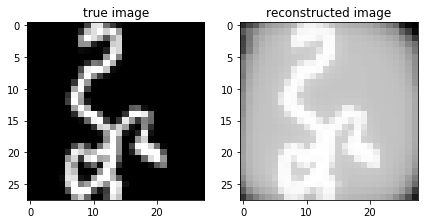

Epoch 1, latent size 784. LOSS: train 0.1707 test 0.0460.


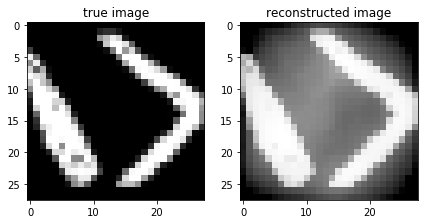

Epoch 2, latent size 774. LOSS: train 0.0481 test 0.0449.


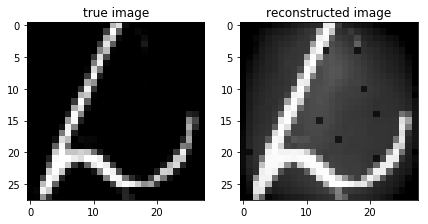

Epoch 3, latent size 774. LOSS: train 0.0462 test 0.0443.


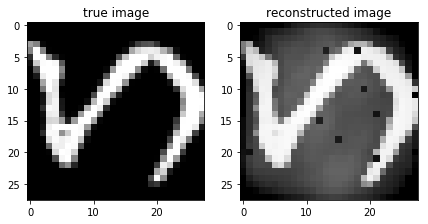

Epoch 4, latent size 774. LOSS: train 0.0456 test 0.0443.


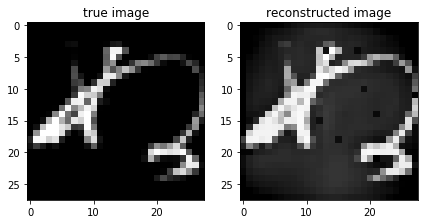

Epoch 5, latent size 764. LOSS: train 0.0470 test 0.0458.


Epoch 6, latent size 764. LOSS: train 0.0472 test 0.0458.


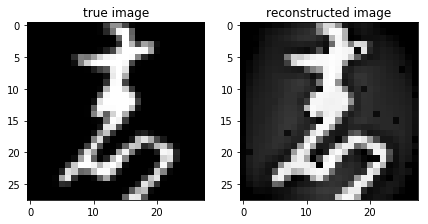

Epoch 7, latent size 764. LOSS: train 0.0473 test 0.0456.


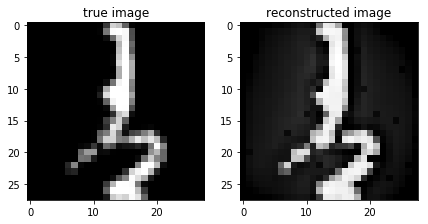

Epoch 8, latent size 754. LOSS: train 0.0481 test 0.0460.


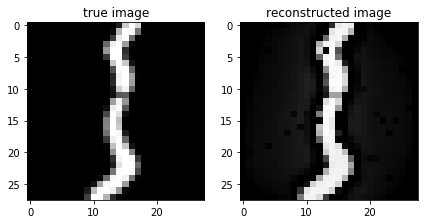

Epoch 9, latent size 754. LOSS: train 0.0475 test 0.0451.


Epoch 10, latent size 754. LOSS: train 0.0465 test 0.0437.


Epoch 11, latent size 744. LOSS: train 0.0465 test 0.0435.


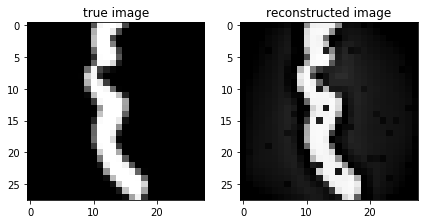

KeyboardInterrupt: 

In [14]:
data_dim = 784
start_size = data_dim

target_size = 4
epochs_per_step = 3
step_size = 10

perf_per_latent = dict()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

history = []
epoch_counter = 0
current_latent_size = start_size

for epoch in range(0, int((start_size - target_size) * epochs_per_step / step_size + epochs_per_step - 1)):
    train_obj = AvgrageMeter()
    test_obj = AvgrageMeter()

    # Reduce latent size every num_epoch epochs
    if epoch_counter == epochs_per_step-1:
        torch.save(model, "trained_models/conv_autoencoder_" + str(current_latent_size))
        
        epoch_counter = 0

        model.reduce_latent_size(step_size)
        perf_per_latent[current_latent_size] = history[-1][1]
        current_latent_size -= step_size
    else:
        epoch_counter += 1

    for images, labels in train_loader:
        predictions = model(images)
        loss = criterion(predictions, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_obj.update(loss.item(), len(images))

    for images, labels in test_loader:
        predictions = model(images)
        loss = criterion(predictions, images)

        test_obj.update(loss.item(), len(images))

    print(f"Epoch {epoch}, latent size {current_latent_size}. LOSS: train {train_obj.avg:.4f} test {test_obj.avg:.4f}.")
    history.append((float(train_obj.avg), float(test_obj.avg)))


    # Printing and plotting
    index = np.random.randint(len(images))
    prediction = predictions[index].detach().numpy().reshape(28, 28)
    true = images[index].detach().numpy().reshape(28, 28)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 14))

    ax1.set_title("true image")
    ax1.imshow(true, cmap='gray')

    ax2.set_title("reconstructed image")
    ax2.imshow(prediction, cmap='gray')
    plt.show()
    
    total_size = 0
